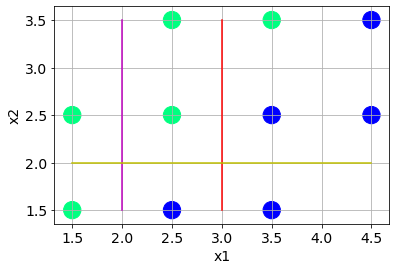

H_0 = 1.0
H_left = -0.0
H_right = 0.9544
IG(x_1 <= 2.0) = 0.2365
H_0 = 1.0
H_left = 0.7219
H_right = 0.7219
IG(x_1 <= 3.0) = 0.2781
H_0 = 1.0
H_left = 0.9183
H_right = 0.9852
IG(x_2 <= 2.0) = 0.03485


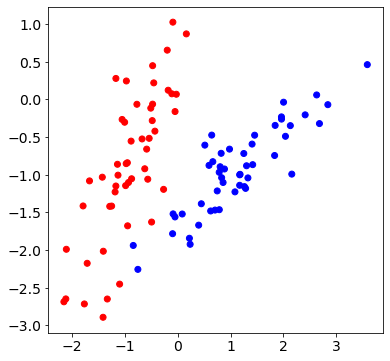

УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -0.95
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 6
      --> Правая ветка:
          ЛИСТ: прогноз = 1, объектов = 6
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 28
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 30


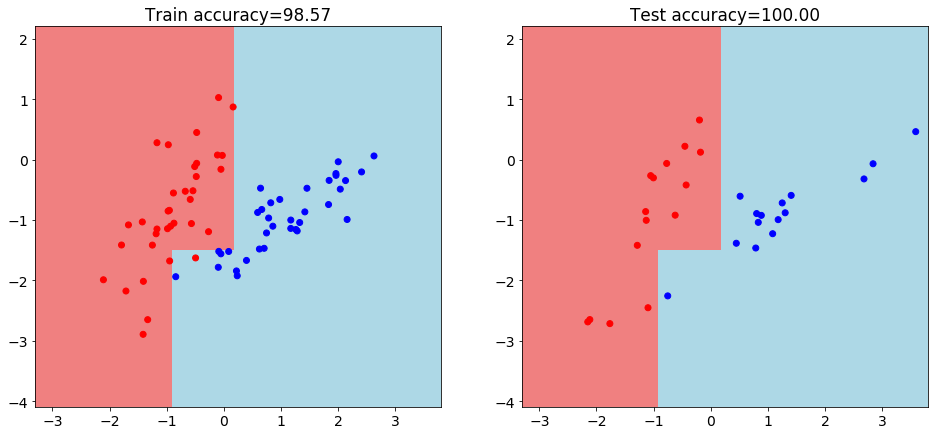

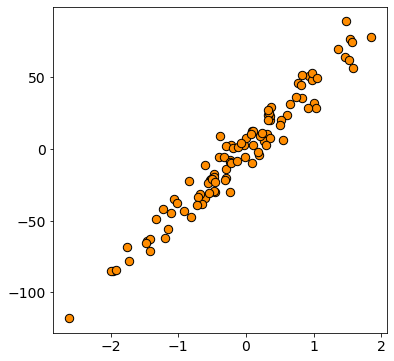

In [1]:
# импортировать всё из урока 4 (вместо того чтобы копировать по частям)
# и заменить отдельные функции на свои согласно заданию
%run ./Lesson_4_170622.ipynb

In [2]:
from graphviz import Digraph

def create_tree(node, tree):
    """создать дерево с помощью модуля graphviz"""

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        tree.node(str(id(node)),
                 label='прогноз = {}\nобъектов = {}'.format(node.prediction, len(node.labels)),
                 shape='oval', color='orange', fontsize='7', margin='0')
        return str(id(node))

    # Выведем значение индекса и порога на этом узле
    tree.node(str(id(node)),
             label='индекс = {}\nпорог = {}'.format(node.index, round(node.t, 2)),
             shape='box', color='green', fontsize='7', margin='0')

    # Рекурсионный вызов функции на положительном поддереве
    tb = create_tree(node.true_branch, tree)
    tree.edge(str(id(node)), tb)

    # Рекурсионный вызов функции на отрицательном поддереве
    lb = create_tree(node.false_branch, tree)
    tree.edge(str(id(node)), lb)
    
    return str(id(node))

In [3]:
def quality(left_labels, right_labels, current_inf_crit, inf_crit_func):
    """расчёт качества"""
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])  
    return current_inf_crit - p * inf_crit_func(left_labels) - (1 - p) * inf_crit_func(right_labels)

1. В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (`min_leaf`), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции `build_tree` и проверьте её работоспособность с помощью визуализации дерева (функция `print_tree()`).

In [4]:
def find_best_split(data, labels, min_leaf=5, inf_crit_func=gini):
    """нахождение наилучшего разбиения"""
  
    current_inf_crit = inf_crit_func(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            # пропускаем разбиения, в которых в узле остаётся менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_inf_crit, inf_crit_func)
            
            # выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [5]:
def build_tree(data, labels, min_leaf=1, max_depth=10**9, max_leaf_nodes=10**9, inf_crit_func=gini,
               _leaves=0, _branches=0, _depth=0):
    """
    построение дерева с помощью рекурсивной функции
    
    :param data: данные
    :param labels: метки
    :param min_leaf: минимальное количество объектов в листе
    :param max_depth: максимальная глубина дерева
    :param max_leaf_nodes: максимальное количество листьев
    :param inf_crit_func: критерий информативности
    :return: узел дерева, кол-во листьев, кол-во ветвей
    """

    quality, t, index = find_best_split(data, labels, min_leaf, inf_crit_func)

    # Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if (quality == 0) or ((max_leaf_nodes - _leaves - _branches) < 2) or (_depth >= max_depth):
        _leaves += 1
        return Leaf(data, labels), _leaves, _branches

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    _branches += 1
    true_branch, _leaves, _branches = build_tree(true_data, true_labels, min_leaf, max_depth, max_leaf_nodes,
                                                 inf_crit_func, _leaves, _branches, _depth+1)
    _branches -= 1
    false_branch, _leaves, _branches = build_tree(false_data, false_labels, min_leaf, max_depth, max_leaf_nodes,
                                                  inf_crit_func, _leaves, _branches, _depth+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch), _leaves, _branches

In [6]:
classification_data, classification_labels = datasets.make_classification(n_samples=100, 
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      random_state=5)

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [7]:
tree_min_leaf, *_ = build_tree(train_data, train_labels, min_leaf=5)

In [8]:
print_tree(tree_min_leaf)

УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -0.95
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 6
      --> Правая ветка:
          ЛИСТ: прогноз = 1, объектов = 6
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 28
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 30


In [9]:
tree_max_depth, *_ = build_tree(train_data, train_labels, max_depth=5)

In [10]:
print_tree(tree_max_depth)

УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -0.95
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 6
      --> Правая ветка:
         УЗЕЛ: индекс = 0, порог = -0.49
         --> Левая ветка:
            УЗЕЛ: индекс = 0, порог = -0.84
            --> Левая ветка:
                ЛИСТ: прогноз = 1, объектов = 1
            --> Правая ветка:
                ЛИСТ: прогноз = 0, объектов = 1
         --> Правая ветка:
             ЛИСТ: прогноз = 1, объектов = 4
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 28
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 30


In [11]:
tree_max_leaf_nodes, *_ = build_tree(train_data, train_labels, max_leaf_nodes=5)

In [12]:
print_tree(tree_max_leaf_nodes)

УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -0.95
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 6
      --> Правая ветка:
         УЗЕЛ: индекс = 0, порог = -0.49
         --> Левая ветка:
             ЛИСТ: прогноз = 1, объектов = 2
         --> Правая ветка:
             ЛИСТ: прогноз = 1, объектов = 4
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 28
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 30


2. (\*) Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.

In [13]:
def shannon(labels):
    """энтропия"""
    # подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    # расчёт критерия
    entropy = 0  # энтропия Шеннона
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p * np.log2(p) if p != 0 else 0
    return entropy

In [14]:
classification_data, classification_labels = datasets.make_classification(n_samples=10**4, 
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      random_state=42)

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=42)

In [15]:
%%time
my_tree_gini, *_ = build_tree(train_data, train_labels, min_leaf=5, inf_crit_func=gini)
# print_tree(my_tree_gini)
train_answers = predict(train_data, my_tree_gini)
answers = predict(test_data, my_tree_gini)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)
print(f"{train_accuracy = }")
print(f"{test_accuracy = }")

train_accuracy = 98.72857142857143
test_accuracy = 98.5
CPU times: user 2min, sys: 11.5 ms, total: 2min
Wall time: 2min


In [16]:
%%time
my_tree_shannon, *_ = build_tree(train_data, train_labels, min_leaf=5, inf_crit_func=shannon)
# print_tree(my_tree_shannon)
train_answers = predict(train_data, my_tree_shannon)
answers = predict(test_data, my_tree_shannon)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)
print(f"{train_accuracy = }")
print(f"{test_accuracy = }")

train_accuracy = 98.8
test_accuracy = 98.53333333333333
CPU times: user 1min 57s, sys: 172 ms, total: 1min 57s
Wall time: 1min 57s


Отличия критерия Джини и энтропии Шеннона:
* Индекс Джини имеет значения внутри интервала [0, 0.5], тогда как интервал энтропии равен [0, 1].
* В вычислительном отношении энтропия более сложна, поскольку использует логарифмы, и, следовательно, вычисление критерия Джини будет происходить быстрее, т.к. там применяется возведение в квадрат.

***Однако получаемые результаты отличаются друг от друга очень незначительно:*** если варьировать параметры у функции построения дерева, то в каких-то случаях достоверность будет выше у Джини, в каких-то - у энтропии, но явного лидера выявить не удаётся.

3. (\*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений. Проверьте точность предсказания дерева на одной из метрик задачи регрессии.

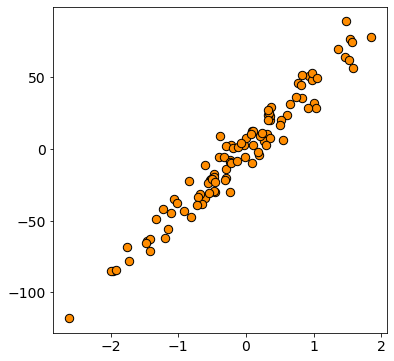

In [17]:
from sklearn import datasets

regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);

In [18]:
# переопределим класс Leaf, заменив у него механизм предсказания
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)  # среднее значение по выборке
        return prediction

In [19]:
# дисперсия значений как критерий информативности
reg_tree, *_ = build_tree(regression_data, regression_labels, min_leaf=5, inf_crit_func=np.var)

In [20]:
print_tree(reg_tree)

УЗЕЛ: индекс = 0, порог = -0.23
--> Левая ветка:
   УЗЕЛ: индекс = 0, порог = -1.15
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -1.72
      --> Левая ветка:
          ЛИСТ: прогноз = -86.65799231942276, объектов = 6
      --> Правая ветка:
          ЛИСТ: прогноз = -59.19707310267859, объектов = 8
   --> Правая ветка:
      УЗЕЛ: индекс = 0, порог = -0.6
      --> Левая ветка:
         УЗЕЛ: индекс = 0, порог = -0.81
         --> Левая ветка:
             ЛИСТ: прогноз = -38.39087022581251, объектов = 6
         --> Правая ветка:
             ЛИСТ: прогноз = -35.27725517230256, объектов = 5
      --> Правая ветка:
         УЗЕЛ: индекс = 0, порог = -0.46
         --> Левая ветка:
            УЗЕЛ: индекс = 0, порог = -0.5
            --> Левая ветка:
                ЛИСТ: прогноз = -21.434094087907813, объектов = 6
            --> Правая ветка:
                ЛИСТ: прогноз = -23.95001980586166, объектов = 5
         --> Правая ветка:
            УЗЕЛ: индекс = 0, порог = -0.3


In [21]:
predicted_labels = predict(regression_data, reg_tree)

In [22]:
def mserror(y, y_pred):
    return np.mean((y - y_pred)**2)
mserror(regression_labels, predicted_labels)

69.42120503167011

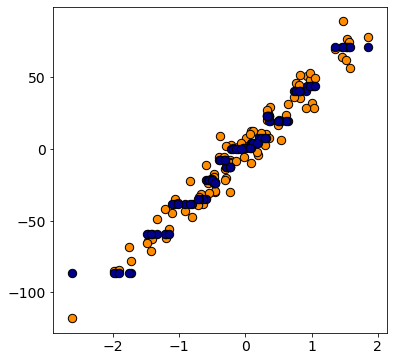

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70)
plt.scatter(regression_data, predicted_labels, c='darkblue', edgecolor='black', s=70);

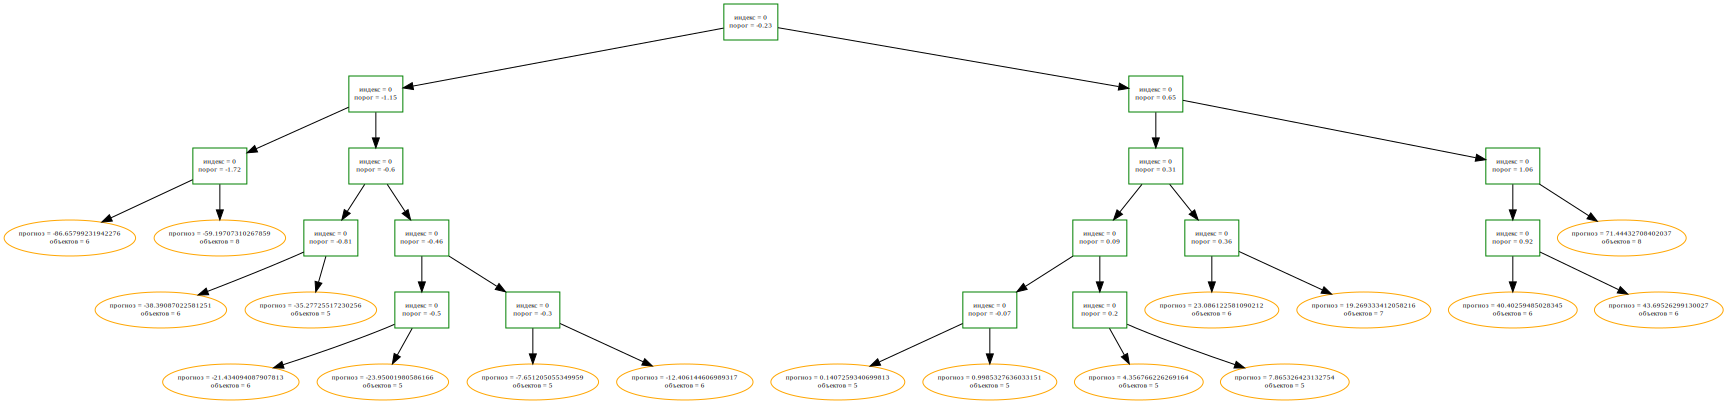

In [24]:
dot = Digraph()  # graph_attr={'ratio': 'auto', 'size': '30, 10!'}   
create_tree(reg_tree, dot)
dot